# Paths and imports handling

In [1]:
import sys
sys.path.insert(0, "..")

from src.path_handling import resolve_path

All relative paths in resolve_path are considered as relative to PROJECT_ROOT directory


# Import necessary libraries

In [ ]:
# Import necessary libraries
import warnings

import pandas as pd

from lightgbm import LGBMRegressor

from src.chemdata.fingerprints import convert_smiles_to_fingerprints, FINGERPRINT_CLASSES
from src.chemdata.splits import load_split_info, DatasetSplits
from src.models.lgbm_search import FingerprintModelSearch, get_lgbm_params, rerun_fit_score_from_study_results

# Fix seed

In [3]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

# Load data

In [4]:
# Load data
data_path = resolve_path("./data/logP_dataset.csv")
data = pd.read_csv(data_path, names=["smiles", "logp"])
print(data)

                                            smiles  logp
0                            C[C@H]([C@@H](C)Cl)Cl   2.3
1                                        C(C=CBr)N   0.3
2                                        CCC(CO)Br   1.3
3      [13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O   2.0
4                                          CCCOCCP   0.6
...                                            ...   ...
14605                                    CCC(SC)Br   2.7
14606                    [2H]C([2H])([C@@H](CO)O)O  -1.8
14607                                     CC(C)NNC   0.4
14608                              C[C@H]1CCC[CH]1   3.4
14609                                   [CH]OC(F)F   1.0

[14610 rows x 2 columns]


# Replace logp with rdkit predictions

(check notebook 01 if you want to know why)

In [5]:
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP

def get_rdkit_logp(smi):
    mol = Chem.MolFromSmiles(smi)
    rdkit_logp = MolLogP(mol)
    return rdkit_logp


data["logp"] = data["smiles"].apply(get_rdkit_logp).values

# Load splits

In [6]:
# Load splits
split_info = load_split_info(
    resolve_path("./data/random_split_info.json")
)
print(f"Train: {len(split_info['train'])}, Val: {len(split_info['val'])}, Test: {len(split_info['test'])}")

Train: 11688, Val: 1461, Test: 1461


# Convert to fingerprints

In [7]:
# Convert to fingerprints
print("Converting SMILES to fingerprints...")
X_data = convert_smiles_to_fingerprints(
    smiles=data["smiles"].tolist(),
    fingerprint_classes=FINGERPRINT_CLASSES
)

Converting SMILES to fingerprints...
[1/7] MorganFingerprint_2048
converting data to MorganFingerprint...


100%|██████████| 14610/14610 [00:13<00:00, 1104.53it/s]


[2/7] FeaturesMorganFingerprint_2048
converting data to FeaturesMorganFingerprint...


100%|██████████| 14610/14610 [00:16<00:00, 884.27it/s]


[3/7] MACCSKeysFingerprint_167
converting data to MACCSKeysFingerprint...


100%|██████████| 14610/14610 [00:03<00:00, 3824.61it/s]


[4/7] RDKitFingerprint_2048
converting data to RDKitFingerprint...


100%|██████████| 14610/14610 [00:15<00:00, 970.42it/s] 


[5/7] AtomPairFingerprint_2048
converting data to AtomPairFingerprint...


100%|██████████| 14610/14610 [00:12<00:00, 1181.26it/s]


[6/7] TopologicalTorsionFingerprint_2048
converting data to TopologicalTorsionFingerprint...


100%|██████████| 14610/14610 [00:13<00:00, 1109.47it/s]


[7/7] AvalonFingerprint_1024
converting data to AvalonFingerprint...


100%|██████████| 14610/14610 [00:08<00:00, 1756.85it/s]


# Create dataset splits object

In [8]:
# Create dataset splits object
splits = DatasetSplits(
    X_data=X_data,
    train_ids=split_info["train"],
    val_ids=split_info["val"],
    test_ids=split_info["test"],
    y_train=data["logp"].iloc[split_info["train"]].values,
    y_val=data["logp"].iloc[split_info["val"]].values,
    y_test=data["logp"].iloc[split_info["test"]].values,
)

# Run hyperparameter search for a single fingerprint (for demonstration)

In [9]:
with warnings.catch_warnings():
    # Ignore useless warnings
    warnings.filterwarnings("ignore", message=r"X does not have valid feature names.*")

    # Run hyperparameter search for a single fingerprint (for demonstration)
    print("Running hyperparameter search for Morgan fingerprint...")
    searcher = FingerprintModelSearch(
        splits=splits,
        fp_name="MorganFingerprint_2048",
        model_cls=LGBMRegressor,
        get_params=get_lgbm_params,
    )
    res = searcher.run(n_trials=10)

[I 2025-12-08 02:00:43,106] A new study created in memory with name: LGBMRegressor_MorganFingerprint_2048


Running hyperparameter search for Morgan fingerprint...


[I 2025-12-08 02:00:44,663] Trial 0 finished with value: 0.29434964953236337 and parameters: {'n_estimators': 425, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 13, 'subsample': 0.4780093202212183, 'colsample_bytree': 0.47799726016810135, 'gamma': 0.05808361216819946, 'reg_alpha': 4.330880728874676, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.29434964953236337.
[I 2025-12-08 02:00:47,287] Trial 1 finished with value: 0.33196397729491894 and parameters: {'n_estimators': 833, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 17, 'subsample': 0.5061695553391381, 'colsample_bytree': 0.49091248360355033, 'gamma': 0.18340450985343382, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.29434964953236337.
[I 2025-12-08 02:00:47,957] Trial 2 finished with value: 0.3366734232189674 and parameters: {'n_estimators': 477, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_c


----------------------------------------------------------------
study 'LGBMRegressor_MorganFingerprint_2048' finished after 10 trials

best_params:
  colsample_bytree: 0.47799726016810135
  gamma: 0.05808361216819946
  learning_rate: 0.2536999076681772
  max_depth: 8
  min_child_weight: 13
  n_estimators: 425
  random_state: 42
  reg_alpha: 4.330880728874676
  reg_lambda: 6.011150117432088
  subsample: 0.4780093202212183
  verbose: -1

best_score: 0.29434964953236337



# Run hyperparameter search for all fingerprints

Here we run hyperparameter search (using Optuna with TPE Sampler) for lgbm regressor on each data representation (fingerprint) and then choose the best model.

During the hyperparameter search we use only one train-val split instead of k-fold cross validation for time economy. 

Score (MAE) on validation is averaged using bootstraping technique.

parameters for lgbm regressor:

random_state: 42 \
verbose: -1 \
n_estimators: [200, 1500] int, log scale \
learning_rate: [0.01, 0.3], float, log scale \
max_depth: [3, 10], int \
min_child_weight: [2, 20], int \
subsample: [0.4, 0.9], float \
colsample_bytree: [0.4, 0.9], float \
gamma: [0, 1], float \
reg_alpha: [0, 5], float \
reg_lambda: [0, 10], float

(this may take a while)

In [ ]:
# Run hyperparameter search for all fingerprints (this may take a while)
print("Running hyperparameter search for all fingerprints...")
all_results = {}

with warnings.catch_warnings():
    # Ignore useless warnings
    warnings.filterwarnings("ignore", message=r"X does not have valid feature names.*")
    
    for k, fp_name in enumerate(FINGERPRINT_CLASSES.keys()):
        print(f"[{k+1}/{len(FINGERPRINT_CLASSES)}] {fp_name}")
        searcher = FingerprintModelSearch(
            splits=splits,
            fp_name=fp_name,
            model_cls=LGBMRegressor,
            get_params=get_lgbm_params,
        )
        res = searcher.run(n_trials=64) # n_trials
        all_results[f"LGBM_{fp_name}"] = res

# Analyze results

In [11]:
# Analyze results
df_results = pd.DataFrame({
    "study_name": list(all_results.keys()),
    "best_score": [v["best_score"] for v in all_results.values()],
})
df_results.sort_values(by="best_score", inplace=True)
print(df_results)

                                study_name  best_score
2            LGBM_MACCSKeysFingerprint_167    0.169825
6              LGBM_AvalonFingerprint_1024    0.218684
0              LGBM_MorganFingerprint_2048    0.248098
4            LGBM_AtomPairFingerprint_2048    0.266134
3               LGBM_RDKitFingerprint_2048    0.281827
1      LGBM_FeaturesMorganFingerprint_2048    0.450046
5  LGBM_TopologicalTorsionFingerprint_2048    0.633799


Best model: LGBM_MACCSKeysFingerprint_167


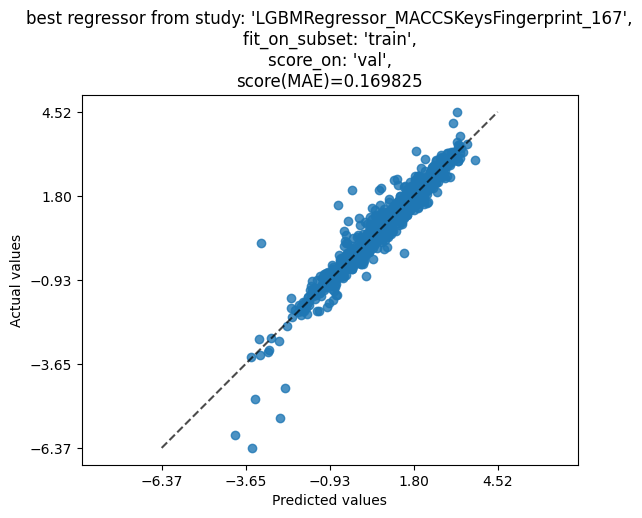

Best model validation score: 0.169824813031164


In [ ]:
# Refit best model on best fingerprint
best_study_name = df_results.iloc[0]["study_name"]
print(f"Best model: {best_study_name}")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=r"X does not have valid feature names.*")
    
    regressor, score = rerun_fit_score_from_study_results(
        results=all_results[best_study_name],
        splits=splits,
        fit_on_subset="train",
        score_on="val"
    )

print(f"Best model validation score: {score}")

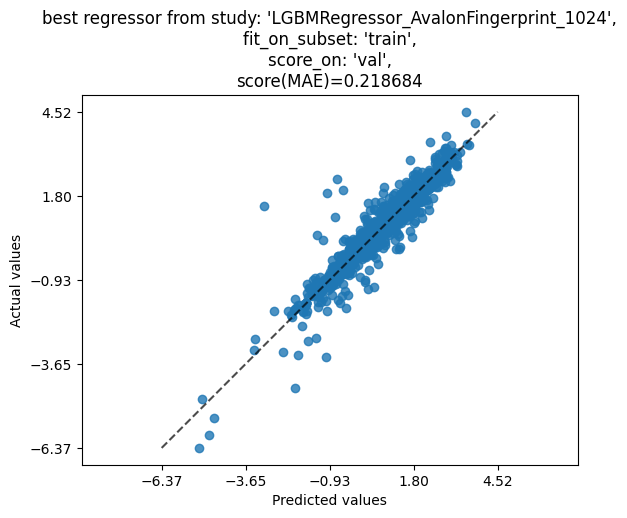

Best model on avalon fingerprint validation score: 0.21868405014963896


In [13]:
# Refit best model on avalon fingerprint
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=r"X does not have valid feature names.*")
    
    regressor, score = rerun_fit_score_from_study_results(
        results=all_results["LGBM_AvalonFingerprint_1024"],
        splits=splits,
        fit_on_subset="train",
        score_on="val"
    )

print(f"Best model on avalon fingerprint validation score: {score}")

# Conclusion

Best quality of fit on validation is obtained with tuning lgbm regressor on **MACCS keys**.

But for **reverse design** of molecules with higher logp we will choose **avalon fingerprint** since it is generally more structural.

However, decision tree based models are hard to interpret in terms of **applicability domain (AD)** of model.

Neural networks (and specifically MLP regressor) are more viable for determination of AD if we consider output of last hidden layer as a "latent space".

Further we will tune and train MLP regressor for better evaluation of AD.